In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Set up and import necessary packages

In [5]:
%pip install xlrd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 1.0 MB/s eta 0:00:00a 0:00:010m
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset

from collections import Counter
import string
from tqdm import tqdm
import matplotlib.pyplot as plt

import re
import subprocess
import tqdm
import time

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('stopwords')        

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Download and unzip wordnet (for kaggle only)
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


# Load and clean dataset

In [13]:
# Load reddit dataset
# data = pd.read_csv('/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv',
#                    names=['review', 'sentiment']).drop(0)
# data.head()

,review,sentiment
1,family mormon have never tried explain them t...,1
2,buddhism has very much lot compatible with chr...,1
3,seriously don say thing first all they won get...,-1
4,what you have learned yours and only yours wha...,0
5,for your own benefit you may want read living ...,1


In [14]:
# Load dataset
data = pd.read_excel('/kaggle/input/sentiment-analysis/datasets.xls',
                     sheet_name='IMDb',
                     header=None,
                     names=['review', 'sentiment']
)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,POSITIVE
1,A wonderful little production. <br /><br />The...,POSITIVE
2,I thought this was a wonderful way to spend ti...,POSITIVE
3,Basically there's a family where a little boy ...,NEGATIVE
4,"Petter Mattei's ""Love in the Time of Money"" is...",POSITIVE


# Split data into train and test sets

In [15]:
def split_data(data_df, test_size, seed=None):
    train_df, validate_test_df = train_test_split(data_df, test_size=test_size, random_state=seed)
    validate_df, test_df = train_test_split(validate_test_df, test_size=0.5, random_state=seed)
    return train_df, validate_df, test_df

In [16]:
seed = 11
train_df, validate_df, test_df = split_data(data, 0.2, seed)
train_df.describe()

,review,sentiment
count,40000,40000
unique,39738,2
top,Loved today's show!!! It was a variety and not...,NEGATIVE
freq,5,20046


In [17]:
train_df.head()

,review,sentiment
10024,Painful. Painful is the only word to describe ...,NEGATIVE
11762,This is a cute little French silent comedy abo...,POSITIVE
43345,I loved this show when it aired on television ...,POSITIVE
33685,It pains me to write such a scathing review bu...,NEGATIVE
23647,"""Stairway to Heaven"" is a outstanding inventio...",POSITIVE


In [18]:
validate_df.describe()

,review,sentiment
count,5000,5000
unique,4999,2
top,Well I guess I know the answer to that questio...,NEGATIVE
freq,2,2522


In [19]:
test_df.describe()

,review,sentiment
count,5000,5000
unique,4998,2
top,Bette Midler is again Divine! Raunchily humoro...,POSITIVE
freq,2,2568


# Convert text to word embeddings

In [20]:
def preprocess(text):
    # Clean dataset i.e. remove <br /> and punctuations
    text = text.lower()
    text = re.sub('<br />', '', text)
    text = re.sub('https://.*','', text)   #remove URLs
    text = re.sub('[^a-zA-Z0-9 ]', '', text)    #remove non-alphanumeric characters 

    # Tokenise and get POS tags of each word
    tokens = word_tokenize(text)
    tags = nltk.pos_tag(tokens)

    # Lemmatization
    lem = WordNetLemmatizer()
    lemmatized = []
    for token, tag in tags:
        pos = tag[0].lower() if tag[0].lower() in ['a', 'r', 'n', 'v'] else 'n'
        lemmatized_token = lem.lemmatize(token, pos=pos)
        lemmatized.append(lemmatized_token)
        
    # Remove stop words
    stop_words = list(stopwords.words('english'))
    filtered_tokens = [token for token in lemmatized if token.lower() not in stop_words]
    
    return filtered_tokens

# Convert reviews to features
def encode_reviews(sentence, vocab):
    features = []
    for word in sentence:
        if word not in vocab.keys():
            features.append(0)
        else:
            features.append(vocab[word])
    features = np.array(features)
    return features

# Pads data to max length
def padding(sentence, max_seq_len):
    """
    Adds padding if sentence length is too short, else truncate sentence to a fixed length.
    Args:
        sentence (np.array): list of preprocessed words in a single review
        max_seq_len (int): max length of a sequence
    Returns:
        list: padded or truncated list of words
    """
    
    # Add padding to sentence
    if len(sentence) < max_seq_len:
        num_padding = max_seq_len - len(sentence)
        padding = np.zeros(num_padding, dtype=int)
        sentence = np.concatenate((sentence, padding))
    
    # Truncate sentence
    else:
        sentence = sentence[:max_seq_len]
            
    return sentence

In [21]:
def preprocess_data(data, max_seq_len, vocab):
    """
    Preprocess data, including tokenisation, lemmatisation, encoding and padding
    Args:
        data (DataFrame): dataframe consisting of x (review) and y (sentiment) data
        max_seq_len (int): max length of x data
        vocab (dict): list of words ordered by descending num of occurences
    Returns:
        numpy_array: preprocessed reviews
        numpy_array: preprocessed sentiments
    """
    
    data_copy = data.copy()

    # Process review
    data_copy['review'] = data_copy['review'].apply(encode_reviews, vocab=vocab)
    x = data_copy['review'].apply(padding, max_seq_len=max_seq_len).to_numpy()
    x = np.vstack(x)
#     x.astype(int)
    
    # Process sentiment
    # TODO: one-hot encode this
    y = np.array([1 if label.strip()=='POSITIVE' else 0 for label in data_copy['sentiment']])
    
    return x, y

In [22]:
def create_dict(data):
    # Create dictionary
    word_list = []
    word_list = data.explode().reset_index(drop=True)

    # Count all the words using Counter Method
    count_words = Counter(word_list)
    sorted_words = count_words.most_common(len(word_list))
    
    # Add unknown (0) into dictionary
    vocab_to_int = {w:i+1 for i,(w,c) in enumerate(sorted_words)}

    return vocab_to_int

In [23]:
# Longest data processing step
start_time = time.time()

train_df['review'] = train_df['review'].apply(preprocess)
time_taken = time.time() - start_time

print(f"time taken: {time_taken/60:.2f}min")


time taken: 11.17min


In [24]:
train_df.head()

,review,sentiment
10024,"[painful, painful, word, describe, awful, rend...",NEGATIVE
11762,"[cute, little, french, silent, comedy, man, be...",POSITIVE
43345,"[love, show, air, television, crush, find, som...",POSITIVE
33685,"[pain, write, scathing, review, im, simply, en...",NEGATIVE
23647,"[stairway, heaven, outstanding, invention, mov...",POSITIVE


In [25]:
# Get vocab from training data
vocab = create_dict(train_df['review'])
list(vocab.items())[:5]

[('movie', 1), ('film', 2), ('one', 3), ('make', 4), ('like', 5)]

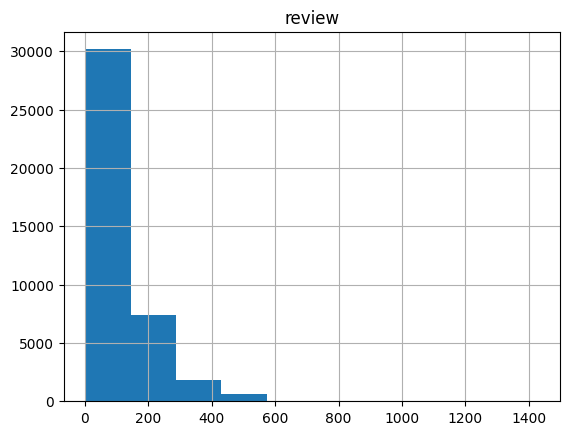

,review
count,40000.000000
mean,119.462525
std,90.111400
min,4.000000
25%,64.000000
50%,89.000000
75%,145.000000
max,1426.000000


In [26]:
# Determine value of max_seq_len
review_len = pd.DataFrame(train_df['review'].apply(len))
review_len.hist()
plt.show()
review_len.describe()

In [27]:
max_seq_len = 250

In [28]:
# Preprocess data
start_time = time.time()

train_x, train_y = preprocess_data(train_df, max_seq_len, vocab)
time_taken = time.time() - start_time

print(f"time taken: {time_taken:.2f}s")
print(f"Shape of x: {train_x.shape}, shape of y: {train_y.shape}")

time taken: 3.00s
Shape of x: (40000, 250), shape of y: (40000,)


In [29]:
# Process validation dataset
start_time = time.time()
validate_df['review'] = validate_df['review'].apply(preprocess)
time_taken = time.time() - start_time

print(f"time taken: {time_taken:.2f}s")

time taken: 83.58s


In [30]:
start_time = time.time()
validate_x, validate_y = preprocess_data(validate_df, max_seq_len, vocab)
time_taken = time.time() - start_time

print(f"time taken: {time_taken:.2f}s")
print(f"Shape of x: {validate_x.shape}, shape of y: {validate_y.shape}")

time taken: 0.39s
Shape of x: (5000, 250), shape of y: (5000,)


In [31]:
# Process test dataset
test_df['review'] = test_df['review'].apply(preprocess)
time_taken = time.time() - start_time

print(f"time taken: {time_taken:.2f}s")

time taken: 84.03s


In [32]:
start_time = time.time()
test_x, test_y = preprocess_data(test_df, max_seq_len, vocab)
time_taken = time.time() - start_time

print(f"time taken: {time_taken:.2f}s")
print(f"Shape of x: {test_x.shape}, shape of y: {test_y.shape}")

time taken: 0.38s
Shape of x: (5000, 250), shape of y: (5000,)


# Custom tensor dataset class

In [33]:
# Turn on GPU before processing further
is_cuda = torch.cuda.is_available()
device = torch.device("cuda") if is_cuda else torch.device("cpu")
device

device(type='cuda')

In [34]:
batch_size = 50
train_dataset = TensorDataset(torch.from_numpy(train_x), torch.Tensor(train_y))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(seed), drop_last=True)

validate_dataset = TensorDataset(torch.from_numpy(validate_x), torch.from_numpy(validate_y))
validate_data_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(seed), drop_last=True)

test_dataset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(seed), drop_last=True)


In [35]:
# obtain one batch of training data
dataiter = iter(train_data_loader)
sample_x, sample_y = next(dataiter)
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print()
print('Sample label size: ', sample_y.size()) # batch_size


Sample input size:  torch.Size([50, 250])

Sample label size:  torch.Size([50])


# Train model

In [36]:
# Using Early stopper to stop when the F1Score prediction drops 
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_f1_score_ = 0
        self.min_accuracy = 0

    def early_stop_f1(self, f1_score):
        if f1_score_ > self.min_f1_score_:
            self.min_f1_score_ = f1_score
            self.counter = 0
        elif f1_score < (self.min_f1_score_ + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def early_stop_accuracy(self, accuracy):
        if accuracy > self.min_accuracy:
            self.min_accuracy = accuracy
            self.counter = 0
        elif accuracy < (self.min_accuracy + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [37]:
import torch.nn as nn
 
class SentimentalLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):    
        """
        Initialize the model by setting up the layers
        """
        super().__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        
        # Dropout layer
        self.dropout=nn.Dropout(p=drop_prob)
        
        # Linear and sigmoid layer
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        
        # Embadding and LSTM output
        embedd = self.embedding(x)
        lstm_out, hidden = self.lstm(embedd, hidden)
        
        # Stack up the lstm output
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # Dropout and fully connected layers
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sigmoid(out)
        
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        """Initialize Hidden STATE"""
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (is_cuda):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
    
def save_model(model, name="model.pth"):
    torch.save(model.state_dict(), name)
    return True

def load_model(model, name="model.pth"):
    loaded_model.load_state_dict(torch.load('model.pth'))
    return True

In [71]:
# # Helper functions to train and test model
# def train_model(model, train_data_loader, validation_data_loader, device, clip, epochs=10, steps=0, print_step=100,
#                 learning_rate=0.001, weights=None, early_stopper=None, debug=True):
#     """
#     Trains the model.
#     Returns:
#         train_accuracies: list[float], contains the training accuracy for each epoch
#         validation_accuracies: list[float], contains the validation accuracy for each epoch
#         train_losses: list[float], contains the training loss for each epoch
#         validation_losses: list[float], contains the validation loss for each epoch
#         time_taken: float, the time taken for the model to run finish
#     """
#     # Lists to store train and test accuracies and losses
#     train_accuracies, validation_accuracies = [], []
#     train_losses, validation_losses = [], []

#     # Define loss function and optimizer
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     loss_fn = nn.BCELoss()
#     h = model.init_hidden(batch_size)
#     model = model.to(device)

#     # Record the start time
#     start_time = time.time()
    
#     # Training loop
#     for epoch in tqdm.tqdm(range(epochs)):
#         # =======================Training=======================
#         model.train()
        
#         train_loss = 0.0
#         total_train, correct_train = 0, 0
        
#         for inputs, labels in train_data_loader:
#             steps += 1
#             batch_inputs, batch_labels = inputs.to(device), labels.to(device)
            
#             # Creating new variables for the hidden state, otherwise
#             # we'd backprop through the entire training history
#             h = tuple([each.data for each in h])

#             # zero accumulated gradients
#             optimizer.zero_grad()

#             # get the output from the model
#             outputs, h = model(batch_inputs, h)

#             # calculate the loss and perform backprop
#             loss = loss_fn(outputs.squeeze(), batch_labels.float())
# #             loss = loss_fn(outputs.squeeze(), batch_labels.float())
#             loss.backward()

#             # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
#             nn.utils.clip_grad_norm_(model.parameters(), clip)
#             optimizer.step()

#             train_loss += loss.item()

#             # Calculate train accuracy
#             predicted = torch.argmax(outputs)
#             total_train += batch_labels.size(0)
#             correct_train += (predicted == batch_labels).sum().item()
#             del batch_inputs, batch_labels
#             torch.cuda.empty_cache()

#             train_accuracy = correct_train / total_train
#             train_accuracies.append(train_accuracy)
#             # Store train loss
#             train_losses.append(train_loss)

#             # =======================Validation=======================
#             if steps % print_step == 0:
#                 model.eval()
#                 val_loss = 0.0
#                 correct_validation, total_validation = 0, 0
#                 val_h = model.init_hidden(batch_size)

#         #         with torch.no_grad():
#                 for inputs, labels in validation_data_loader:
#                     # Creating new variables for the hidden state, otherwise
#                     # we'd backprop through the entire training history
#                     val_h = tuple([each.data for each in val_h])

#                     batch_inputs, batch_labels = inputs.to(device), labels.to(device)

#                     outputs, val_h = model(batch_inputs, val_h)

#         #                 loss = loss_fn(outputs, batch_labels.view(-1).float())
#                     loss = loss_fn(outputs.squeeze(), batch_labels.float())
#                     val_loss += loss.item()

#                     # Calculate test accuracy
#                     predicted = torch.argmax(outputs)
#                     total_validation += batch_labels.size(0)
#                     correct_validation += (predicted == batch_labels).sum().item()
                    
#                     model.train()

#                 validation_accuracy = correct_validation / total_validation
#                 validation_accuracies.append(validation_accuracy)
#                 validation_losses.append(val_loss)  # Store test loss

#                 # Print validation results
#                 if debug:
#                     print(f"Steps: {steps}\nTrain loss: {train_losses[-1]:.4f}\nValidation loss: {validation_losses[-1]:.4f}\nTrain accuracy: {train_accuracy:.4f}\nValidation accuracy: {validation_accuracy:.4f}")

#         # Print epoch results
#         if debug:
#             print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {validation_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

#         # Check for early stopping
#         if early_stopper and early_stopper.early_stop_accuracy(validation_accuracy):
#             print(f"Early stopping at epoch ({epoch+1}) due to no improvement in accuracy.")
#             break

#     time_taken = time.time() - start_time
#     print(f"Time taken for the model to run finish: {time_taken:.2f} seconds")
#     torch.cuda.empty_cache()  # Release cache
#     return train_accuracies, validation_accuracies, train_losses, validation_losses, time_taken



In [72]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab) + 1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

model = SentimentalLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(model)

SentimentalLSTM(
  (embedding): Embedding(179843, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [74]:
def train_model(model, train_data_loader, validate_data_loader, device, lr=0.001, counter=0, epochs=50, print_every=100, clip=5, early_stopper=None):
    model.to(device)
    
    start_time = time.time()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # train for some number of epochs
    for e in tqdm.tqdm(range(epochs)):
        model.train()
        # initialize hidden state
        h = model.init_hidden(batch_size)

        # ============================ Train Model ==================================
        for inputs, labels in train_data_loader:
            counter += 1

            if(is_cuda):
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Creating new variables for the hidden state, otherwise it will backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            optimizer.zero_grad()

            # get the output from the model
            output, h = model(inputs, h)

            # calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()

            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()

            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = model.init_hidden(batch_size)
                val_losses = []
                model.eval()
                
                # ============================== Validate Model ======================================
                for inputs, labels in validate_data_loader:

                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])

                    inputs, labels = inputs.cuda(), labels.cuda()
                    output, val_h = model(inputs, val_h)
                    val_loss = criterion(output.squeeze(), labels.float())

                    val_losses.append(val_loss.item())
            
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
                
                validation_accuracy = correct_validation / total_validation

        # Check for early stopping
        if early_stopper and early_stopper.early_stop_accuracy(validation_accuracy):
            print(f"Early stopping at epoch ({epoch+1}) due to no improvement in accuracy.")
            break
                
    time_taken = time.time() - start_time
    print(f"Time taken for the model to run finish: {time_taken:.2f} seconds")
    torch.cuda.empty_cache()  # Release cache

In [75]:
early_stopper = EarlyStopper(patience=5)

# loss and optimization functions
lr=0.001

# training params
epochs = 10 # 3-4 is approx where I noticed the validation loss stop decreasing
counter = 0
print_every = 100
clip = 5 # gradient clipping

# train_accuracies, validation_accuracies, train_losses, validation_losses, time_taken = train_model(model, train_data_loader,
#                                     validation_data_loader=validate_data_loader, device=device, clip=5, debug=True)
train_model(model, train_data_loader, validate_data_loader, device)

Epoch: 1/50... Step: 100... Loss: 80.656029... Val Loss: 91.122660
Epoch: 1/50... Step: 200... Loss: 96.354126... Val Loss: 91.155367
Epoch: 1/50... Step: 300... Loss: 64.882690... Val Loss: 91.451450
Epoch: 1/50... Step: 400... Loss: 96.354050... Val Loss: 91.362407
Epoch: 1/50... Step: 500... Loss: 57.329411... Val Loss: 91.446621
Epoch: 1/50... Step: 600... Loss: 105.961205... Val Loss: 91.088501
Epoch: 1/50... Step: 700... Loss: 92.313782... Val Loss: 91.491643
Epoch: 1/50... Step: 800... Loss: 89.211678... Val Loss: 91.352030
Epoch: 2/50... Step: 900... Loss: 92.318466... Val Loss: 91.132832
Epoch: 2/50... Step: 1000... Loss: 76.879242... Val Loss: 91.057161
Epoch: 2/50... Step: 1100... Loss: 100.411697... Val Loss: 91.188705
Epoch: 2/50... Step: 1200... Loss: 125.786896... Val Loss: 91.581360
Epoch: 2/50... Step: 1300... Loss: 93.433578... Val Loss: 91.250137
Epoch: 2/50... Step: 1400... Loss: 113.303963... Val Loss: 91.092247
Epoch: 2/50... Step: 1500... Loss: 85.214409... Val L

In [56]:
def test_model(model, test_data_loader, device):
    """
    Tests the model.
    Returns:
        predicted_labels: list[int], contains the predicted labels for the test data
        actual_labels: list[int], contains the actual labels for the test data
        test_accuracy: float, the test accuracy
    """
    model = model.to(device)
    # Initialise hidden state
    h = model.init_hidden(batch_size)
    model.eval()
    
    # Variables to track accuracy
    correct_test, total_test = 0, 0
    
    # Lists to store predicted and actual labels
    predicted_labels = []
    actual_labels = []

    # Record the start time
    start_time = time.time()
    # =======================Testing=======================
    with torch.no_grad():
        for inputs, labels in test_data_loader:
            batch_inputs, batch_labels = inputs.to(device), labels.to(device)

            outputs, h = model(batch_inputs, h)

            # Calculate test accuracy
            predicted = torch.argmax(outputs)
            total_test += batch_labels.size(0)
            correct_test += (predicted == batch_labels).sum().item()

            # Append predicted and actual labels to the lists
            predicted_labels.extend([predicted.tolist()])
            actual_labels.extend(batch_labels.tolist())

    time_taken = time.time() - start_time

    test_accuracy = correct_test / total_test
    print(f"Time taken to run finish the test: {time_taken:.2f} seconds")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    torch.cuda.empty_cache()  # Release cache
    return predicted_labels, actual_labels, test_accuracy

In [58]:
predicted_labels, actual_labels, test_accuracy = test_model(model, test_data_loader=test_data_loader, device=device)
actual_labels

Time taken to run finish the test: 1.85 seconds
Test Accuracy: 0.0390


[1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,


In [48]:
# Get test data loss and accuracy
test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_data_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(is_cuda):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not is_cuda else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_data_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 94.526
Test accuracy: 0.861
